In [8]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from utils import vis_hybrid_image, load_image, save_image
from student_code import my_imfilter, create_hybrid_image
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


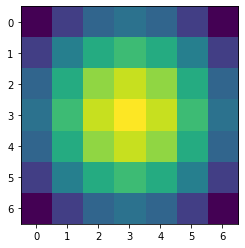

In [67]:
cutoff_frequency = 7
# filter = cv2.getGaussianKernel(ksize=cutoff_frequency*4+1,
#                                sigma=cutoff_frequency)
filter = cv2.getGaussianKernel(ksize=7,
                               sigma=3)
filter = np.dot(filter, filter.T)

# let's take a look at the filter!
plt.figure(figsize=(4,4)); plt.imshow(filter);

In [68]:
filter

array([[0.01129725, 0.01491455, 0.01761946, 0.01862602, 0.01761946,
        0.01491455, 0.01129725],
       [0.01491455, 0.01969008, 0.02326108, 0.02458993, 0.02326108,
        0.01969008, 0.01491455],
       [0.01761946, 0.02326108, 0.02747972, 0.02904957, 0.02747972,
        0.02326108, 0.01761946],
       [0.01862602, 0.02458993, 0.02904957, 0.03070911, 0.02904957,
        0.02458993, 0.01862602],
       [0.01761946, 0.02326108, 0.02747972, 0.02904957, 0.02747972,
        0.02326108, 0.01761946],
       [0.01491455, 0.01969008, 0.02326108, 0.02458993, 0.02326108,
        0.01969008, 0.01491455],
       [0.01129725, 0.01491455, 0.01761946, 0.01862602, 0.01761946,
        0.01491455, 0.01129725]])

In [69]:
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Surface(z=filter)])
fig.show()

In [70]:
int(filter.shape[0]/2)

3

In [71]:
filter.shape

(7, 7)

In [72]:
A = []
A = list(range(1,int(filter.shape[0]/2)+2))
A = A + A[::-1][1:]
B = [1]*int(filter.shape[0]/2)
B = B + [0] + [-x for x in B]
Ax = np.asarray(A)
By = np.asarray(B)
filter_high_x = np.outer(np.transpose(A),B)
filter_high_x

array([[ 1,  1,  1,  0, -1, -1, -1],
       [ 2,  2,  2,  0, -2, -2, -2],
       [ 3,  3,  3,  0, -3, -3, -3],
       [ 4,  4,  4,  0, -4, -4, -4],
       [ 3,  3,  3,  0, -3, -3, -3],
       [ 2,  2,  2,  0, -2, -2, -2],
       [ 1,  1,  1,  0, -1, -1, -1]])

In [20]:
np.array([[i] * 10 for i in range(filter.shape[0])]).ravel()

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [ ]:
def create_hybrid_image(image1, image2, filter,first_weight,filter_type):
  """
  Takes two images and creates a hybrid image. Returns the low
  frequency content of image1, the high frequency content of
  image 2, and the hybrid image. 

  Filter type of 1 generates the inverse of a Gaussian filter with the central point 
  at the inverse peak. The second type of filter generates the (N*N) sobel filter.

  Args
  - image1: numpy nd-array of dim (m, n, c)
  - image2: numpy nd-array of dim (m, n, c)
  Returns
  - low_frequencies: numpy nd-array of dim (m, n, c)
  - high_frequencies: numpy nd-array of dim (m, n, c)
  - hybrid_image: numpy nd-array of dim (m, n, c)

  HINTS:
  - You will use your my_imfilter function in this function.
  - You can get just the high frequency content of an image by removing its low
    frequency content. Think about how to do this in mathematical terms.
  - Don't forget to make sure the pixel values are >= 0 and <= 1. This is known
    as 'clipping'.
  - If you want to use images with different dimensions, you should resize them
    in the notebook code.
  """

  assert image1.shape[0] == image2.shape[0]
  assert image1.shape[1] == image2.shape[1]
  assert image1.shape[2] == image2.shape[2]

  ############################
  ### TODO: YOUR CODE HERE ###
  # low pass filter is the normal gaussian distribution
  low_frequencies = my_imfilter(image1,filter)
  if filter_type == 1:
    # high pass filter is the negative of the gaussian distribution
    h=-filter
    h[int(filter.shape[0]/2),int(filter.shape[0]/2)] = filter[int(filter.shape[0]/2),int(filter.shape[0]/2)]
    h[int(filter.shape[0]/2),int(filter.shape[0]/2)] = h[int(filter.shape[0]/2),int(filter.shape[0]/2)] -h.sum()
    high_frequencies = my_imfilter(image2,h)
  elif filter_type == 2:
    # create the high pass sobel filter for x and y
    A = []
    A = list(range(1,int(filter.shape[0]/2)+2))
    A = A + A[::-1][1:]
    B = [1]*int(filter.shape[0]/2)
    B = B + [0] + [-x for x in B]
    Ax = np.asarray(A)
    By = np.asarray(B)

    filter_high_x = np.outer(np.transpose(Ax),By)
    print(filter_high_x)
    normalization_coeff = filter_high_x[0:int(filter_high_x.shape[0]/2),0:int(filter_high_x.shape[0]/2)].sum()*4 + filter_high_x[int(filter_high_x.shape[0]/2)][:int(filter_high_x.shape[0]/2)].sum()*2
    #print(normalization_coeff)
    filter_high_x = filter_high_x /normalization_coeff
    print(filter_high_x)
    # now we create the filter for only X gradient
    high_frequencies_1 = my_imfilter(image2,filter_high_x)
    filter_high_y = np.transpose(filter_high_x)
    high_frequencies_2 = my_imfilter(image2,filter_high_y)
    high_frequencies = 0.5 * high_frequencies_1 + 0.5 * high_frequencies_2
    high_frequencies = high_frequencies_1
    
  
  hybrid_image = first_weight*low_frequencies + (1-first_weight)*high_frequencies
  ### END OF STUDENT CODE ####
  ############################

  return low_frequencies, high_frequencies, hybrid_image